## **Sky nebular emission**
**Author**: Chiara Virzì


This notebook is used to make the average out of ten file fits of sky (without an emitting object) spectrum provided to calculate the mean data and use it as nebular emission.
The used libraries are the following:

In [2]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [3]:
# Define the folder containing the FITS files
folder = 'sky'

# Define the wavelength window
window_min = 6538.0
window_max = 6590.0

# Hα line wavelength
Ha_wavelength = 6562.8  

# Function to read FITS files
def read_fits(file):
    with fits.open(file) as hdul:
        data = hdul[0].data
        header = hdul[0].header

        if data is None:
            raise ValueError(f"File {file} contains no valid data.")

        # Read X-axis parameters with error handling
        crval1 = header.get('CRVAL1', 0)
        crpix1 = header.get('CRPIX1', 1)  # Avoid division by zero
        cdelt1 = header.get('CDELT1', 1)
        n_pixels = header.get('NAXIS1', len(data))

        if n_pixels != len(data):
            raise ValueError(f"X-axis size and data mismatch in {file}.")

        # Construct X-axis (wavelength)
        x = crval1 + (np.arange(n_pixels) - (crpix1 - 1)) * cdelt1
        
        # Apply the wavelength window filter
        mask = (x > window_min) & (x <= window_max)
        x_zoomed = x[mask]
        y_zoomed = data[mask]

        
    return x_zoomed, y_zoomed

### Automatic Hα line Detection

The following cell defines a function that automatically detects the wavelength boundaries of the Hα spectral line, centered at 6562.8 Å. It does this by analyzing the derivative of the flux within a narrow ±5 Å window around the line, looking for sharp changes that correspond to the start and end of the emission or absorption feature.


In [4]:
# Function to find Hα edges
def find_Ha(x, y):
    #Identifies the limits of the Hα within a restricted window around 6562.8 Å.
    derivative = np.gradient(y, x)  # Compute spectrum derivative

    # Select only the ±5 Å window around Hα
    mask_Ha = (x > Ha_wavelength - 5) & (x < Ha_wavelength + 5)
    x_Ha = x[mask_Ha]
    derivative_Ha = derivative[mask_Ha]

    if len(x_Ha) == 0:
        return Ha_wavelength - 2, Ha_wavelength + 2 

    # Set a threshold to detect significant changes in the derivative
    threshold = 0.1 * np.max(np.abs(derivative_Ha))  # 10% of max variation
    transitions = np.where(np.abs(derivative_Ha) > threshold)[0]

    # If significant changes are found, return the first and last as limits
    if len(transitions) > 2:
        idx_min = transitions[0]  # First change point
        idx_max = transitions[-1]  # Last change point
        return x_Ha[idx_min], x_Ha[idx_max]

    return Ha_wavelength - 2, Ha_wavelength + 2  # Default if nothing is found

### Visualization

This cell processes a folder of FITS spectra to automatically identify the boundaries of the Hα line using the `find_Ha` function. It computes the average wavelength limits across all spectra, selects one representative file, and plots the spectrum with vertical lines marking the estimated start and end of the Hα feature.


sky-C20111203_00001_st.0001.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


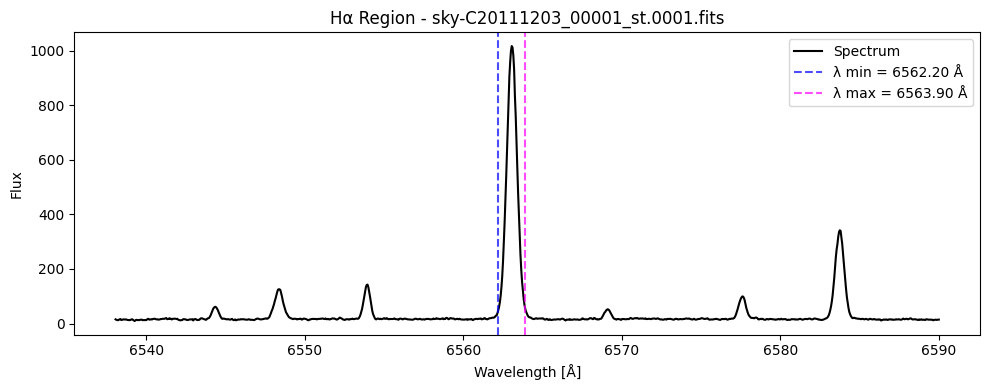

sky-C20111203_00001_st.0002.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


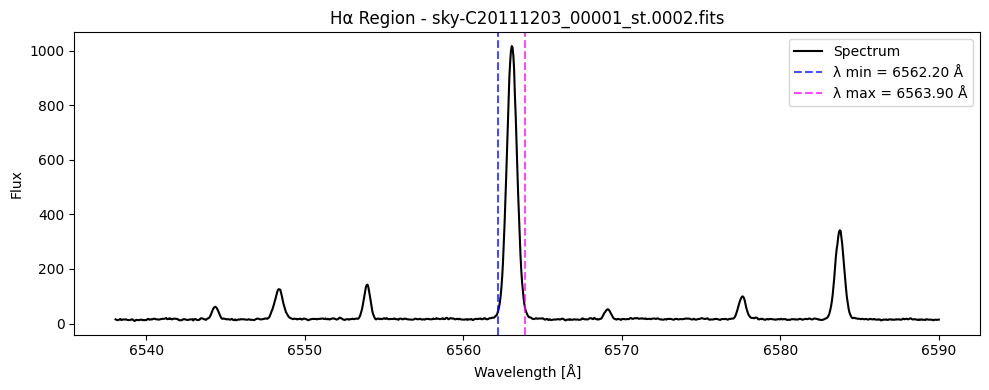

sky-C20111203_00001_st.0003.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


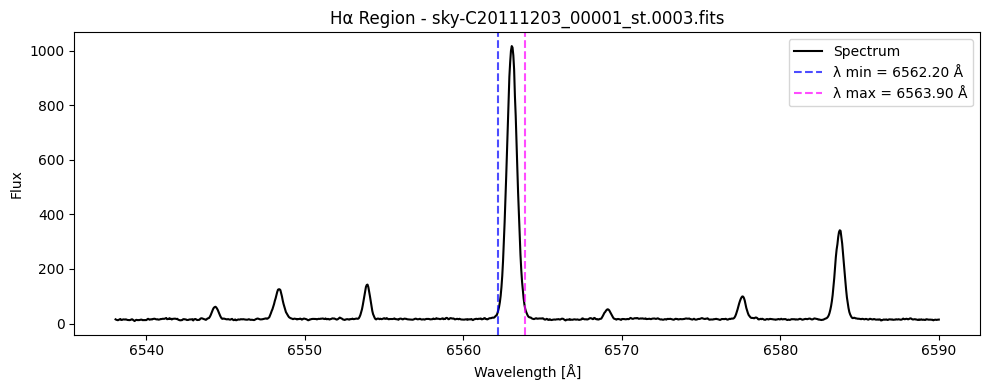

sky-C20111203_00001_st.0004.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


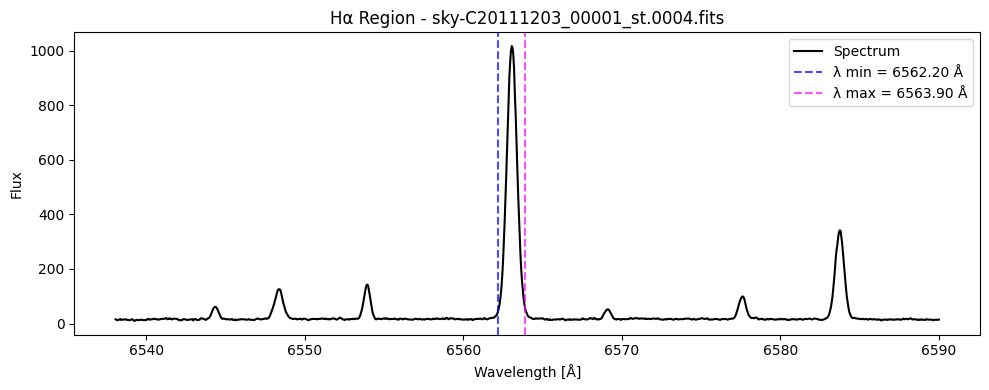

sky-C20111203_00001_st.0005.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


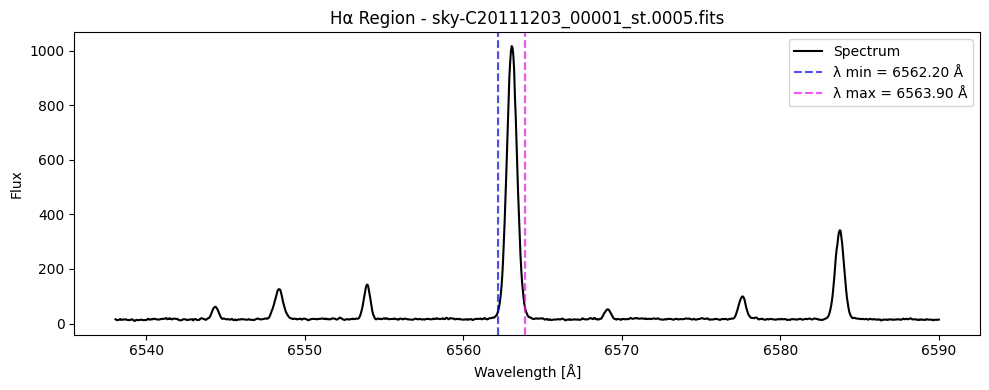

sky-C20111203_00001_st.0006.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


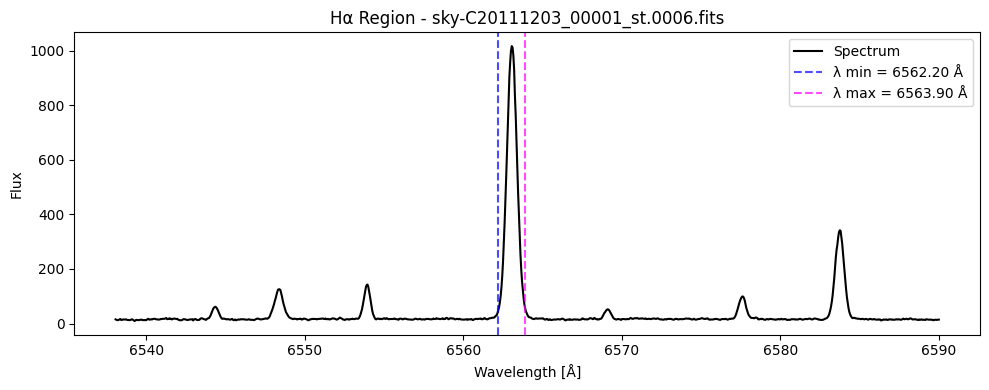

sky-C20111203_00001_st.0007.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


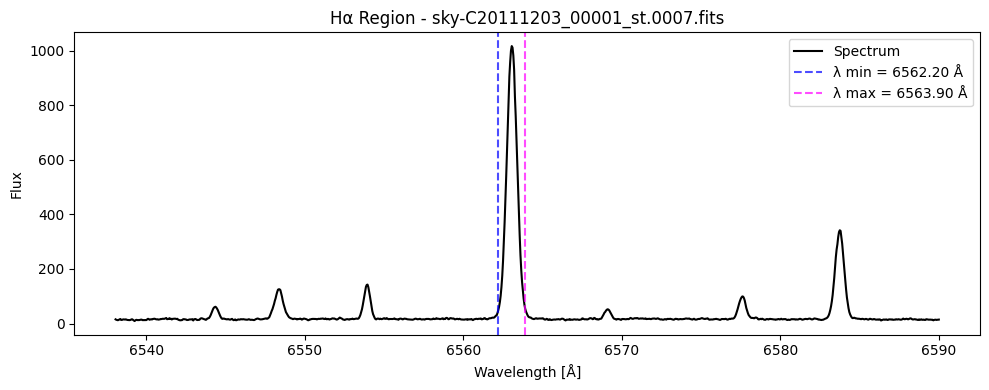

sky-C20111203_00001_st.0008.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


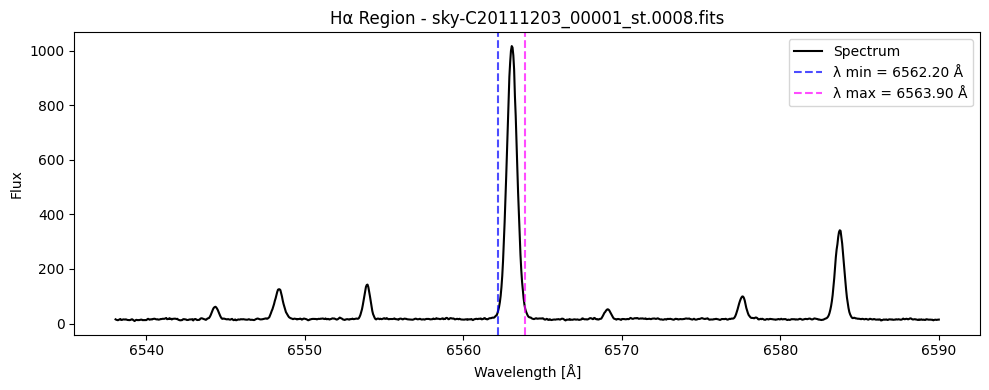

sky-C20111203_00001_st.0009.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


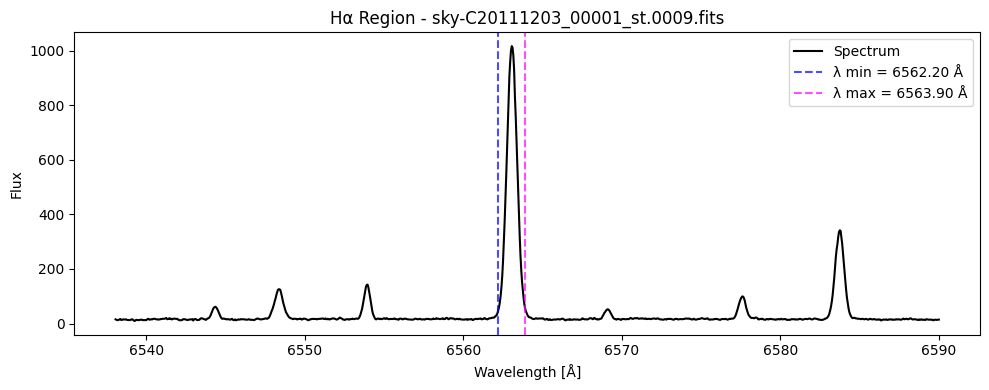

sky-C20111203_00001_st.0010.fits: λ_min = 6562.20 Å, λ_max = 6563.90 Å, FWZI = 1.70 Å


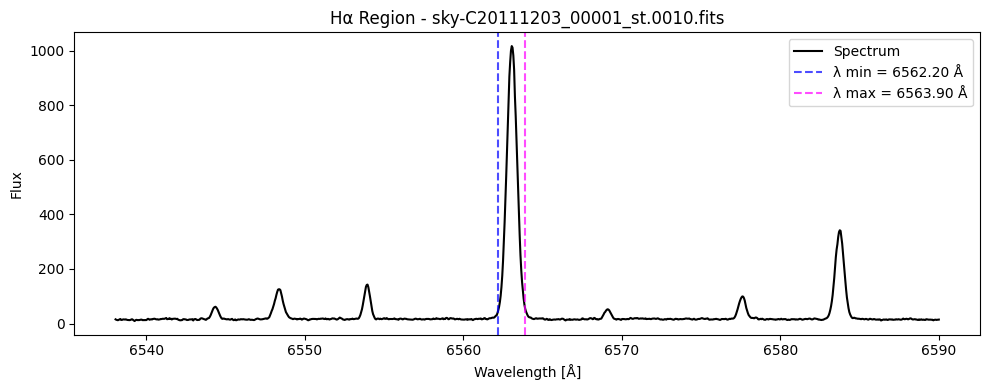


--- Averages ---
Average λ min: 6562.20 Å
Average λ max: 6563.90 Å
Average FWZI: 1.70 Å


In [5]:
# List all FITS files in the folder
fits_files = [f for f in os.listdir(folder) if f.endswith('.fits')]

# Initialize lists to store the min/max wavelengths and FWZI
lambda_mins = []
lambda_maxs = []
widths = []

# Loop through all FITS files to extract and plot Hα region info
for file in fits_files:
    file_path = os.path.join(folder, file)
    try:
        # Read wavelength (x_filt) and intensity (y_filt)
        x_filt, y_filt = read_fits(file_path)

        # Find the Hα line boundaries
        lambda_min, lambda_max = find_Ha(x_filt, y_filt)
        width = lambda_max - lambda_min

        # Store values
        lambda_mins.append(lambda_min)
        lambda_maxs.append(lambda_max)
        widths.append(width)

        # Print values for each file
        print(f"{file}: λ_min = {lambda_min:.2f} Å, λ_max = {lambda_max:.2f} Å, FWZI = {width:.2f} Å")

        # Plot the spectrum
        plt.figure(figsize=(10, 4))
        plt.plot(x_filt, y_filt, label="Spectrum", color='black')
        plt.axvline(lambda_min, color='blue', linestyle='--', alpha=0.7, label=f"λ min = {lambda_min:.2f} Å")
        plt.axvline(lambda_max, color='magenta', linestyle='--', alpha=0.7, label=f"λ max = {lambda_max:.2f} Å")

        # Customize plot
        plt.xlabel("Wavelength [Å]")
        plt.ylabel("Flux")
        plt.title(f"Hα Region - {file}")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()
        plt.close()

    except Exception as e:
        print(f"Error reading {file}: {e}")

# Print average values after looping through all files
if lambda_mins and lambda_maxs:
    avg_lambda_min = np.mean(lambda_mins)
    avg_lambda_max = np.mean(lambda_maxs)
    avg_width = np.mean(widths)

    print("\n--- Averages ---")
    print(f"Average λ min: {avg_lambda_min:.2f} Å")
    print(f"Average λ max: {avg_lambda_max:.2f} Å")
    print(f"Average FWZI: {avg_width:.2f} Å")

